In [1]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import torch
import pandas as pd
from tqdm.notebook import tqdm

In [3]:
! unzip "/content/drive/My Drive/AV_sentiment_analysis.zip"
! ls

Archive:  /content/drive/My Drive/AV_sentiment_analysis.zip
  inflating: test_oJQbWVk.csv        
  inflating: train_2kmZucJ.csv       
  inflating: sample_submission_LnhVWA4.csv  
drive	     sample_submission_LnhVWA4.csv  train_2kmZucJ.csv
sample_data  test_oJQbWVk.csv


In [9]:
train = pd.read_csv("./train_2kmZucJ.csv")
test = pd.read_csv("./test_oJQbWVk.csv")
train.head()

,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,2,0,Finally a transparant silicon case ^^ Thanks t...
2,3,0,We love this! Would you go? #talk #makememorie...
3,4,0,I'm wired I know I'm George I was made that wa...
4,5,1,What amazing service! Apple won't even talk to...


In [10]:
train.set_index("id", inplace=True)
train.head()

,label,tweet
id,,
1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
2,0,Finally a transparant silicon case ^^ Thanks t...
3,0,We love this! Would you go? #talk #makememorie...
4,0,I'm wired I know I'm George I was made that wa...
5,1,What amazing service! Apple won't even talk to...


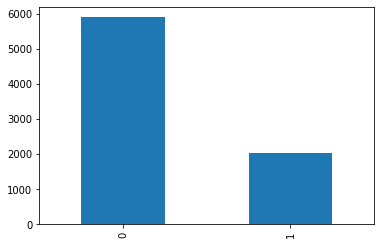

In [11]:
train["label"].value_counts().plot(kind="bar")

In [14]:
import re
def clean_text(data):
    data["tweet"] = data["tweet"].apply(lambda x: " ".join(x.lower() for x in x.split()))
    data["tweet"] = data["tweet"].str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '')
    data["tweet"] = data["tweet"].str.replace("[^\w\s]", " ")

    return data

train = clean_text(train)
test = clean_text(test)
train.head()

,label,tweet
id,,
1,0,fingerprint pregnancy test android apps ...
2,0,finally a transparant silicon case thanks t...
3,0,we love this would you go talk makememorie...
4,0,i m wired i know i m george i was made that wa...
5,1,what amazing service apple won t even talk to...


In [15]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    train.index.values,
    train.label.values,
    test_size=0.15,
    random_state=42,
    stratify=train.label.values
)

In [16]:
train["type"] = ["not_set"] * train.shape[0]
train.head()

,label,tweet,type
id,,,
1,0,fingerprint pregnancy test android apps ...,not_set
2,0,finally a transparant silicon case thanks t...,not_set
3,0,we love this would you go talk makememorie...,not_set
4,0,i m wired i know i m george i was made that wa...,not_set
5,1,what amazing service apple won t even talk to...,not_set


In [17]:
train.loc[X_train, "type"] = "train"
train.loc[X_val, "type"] = "val"

In [18]:
train.groupby(["label", "type"]).count()

tweet
label type        
0     train   5010
      val      884
1     train   1722
      val      304

In [19]:
! pip install transformers

     |████████████████████████████████| 675kB 7.1MB/s 
     |████████████████████████████████| 1.1MB 18.2MB/s 
     |████████████████████████████████| 3.8MB 39.2MB/s 
     |████████████████████████████████| 890kB 38.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=45fccf7500b99148c529ebec242164505d820b5d068059996d8992fb874decad
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [20]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

In [25]:
max_len = max([len(x.split()) for x in train.tweet])

In [26]:
tokenizer = BertTokenizer.from_pretrained(
    "bert-base-uncased",
    do_lower_case=True
)

In [27]:
encoded_train = tokenizer.batch_encode_plus(
    train[train.type=="train"].tweet.values,
    # tokens whcih BERT uses to identify START, END, SEP
    add_special_tokens=True,
    # MASKING 0 FOR INVALID OR EXTENDED WORDS
    return_attention_masks=True,
    # PADDING TO MAKE SURE ALL INPUTS ARE OF SAME LENGTH
    pad_to_max_length=True,
    # MAX LENGTH
    max_length=max_len,
    # TENSORS SUITED FOR PYTORCH
    return_tensors="pt"
)

encoded_valid = tokenizer.batch_encode_plus(
    train[train.type=="val"].tweet.values,
    # tokens whcih BERT uses to identify START, END, SEP
    add_special_tokens=True,
    # MASKING 0 FOR INVALID OR EXTENDED WORDS
    return_attention_masks=True,
    # PADDING TO MAKE SURE ALL INPUTS ARE OF SAME LENGTH
    pad_to_max_length=True,
    # MAX LENGTH
    max_length=max_len,
    # TENSORS SUITED FOR PYTORCH
    return_tensors="pt"
)

In [28]:
input_ids_train = encoded_train["input_ids"]
attention_masks_train = encoded_train["attention_mask"]
labels_train = torch.tensor(train[train.type=="train"].label.values)

input_ids_val = encoded_valid["input_ids"]
attention_masks_val = encoded_valid["attention_mask"]
labels_val = torch.tensor(train[train.type=="val"].label.values)

In [29]:
train_dataset = TensorDataset(input_ids_train, attention_masks_train, labels_train)
val_dataset = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [30]:
print("Training Dataset", len(train_dataset))
print("Validation Dataset", len(val_dataset))

Training Dataset 6732
Validation Dataset 1188


In [31]:
# sample of our data
none = next(iter(train_dataset))
print(none)

(tensor([  101,  4344, 16550, 10032,  3231, 11924, 18726,  3376, 10140,  2740,
         1045, 15776, 18059,  2239,  2135, 18059,  8464, 18059,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]), tensor(0))


In [34]:
num_labels = len(train.label.unique())

In [35]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=num_labels,
    output_attentions=False,
    output_hidden_states=False
)

In [36]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

BATCH_SIZE=32

train_loader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=BATCH_SIZE
)

val_loader = DataLoader(
    train_dataset,
    sampler=SequentialSampler(train_dataset),
    batch_size=64
)

In [37]:
from transformers import AdamW, get_linear_schedule_with_warmup

EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader)*EPOCHS)

In [49]:
import numpy as np
from sklearn.metrics import f1_score

def f1score(pred, labels):
    preds_flat = np.argmax(pred, axis=1).flatten()
    labels_flat = labels.flatten()

    return f1_score(labels_flat, preds_flat, average="weighted")

def accuracy_per_class(preds, labels):

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f"Class: {label}")
        print(f"Accuracy: {(len(y_preds[y_preds==label])/len(y_true))}\n")


In [39]:
import random

seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)
print(device)

cuda


In [41]:
def evaluate(dataloader_val):
    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:
        batch = tuple(b.to(device) for b in batch)
        inputs = {
            "input_ids": batch[0],
            "attention_mask": batch[1],
            "labels": batch[2]
        }

        with torch.no_grad():
            outputs = model(**inputs)
        
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs["labels"].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total / len(dataloader_val)
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

In [43]:
for epoch in tqdm(range(1, EPOCHS+1)):
    model.train()
    loss_train_total = 0.0

    progress_bar = tqdm(train_loader, desc="Epoch {:1d}".format(epoch), leave=False, disable=False)

    for batch in progress_bar:
        model.zero_grad()

        batch = tuple(b.to(device) for b in batch)

        inputs = {
            "input_ids": batch[0],
            "attention_mask": batch[1],
            "labels": batch[2]
        }

        outputs = model(**inputs)

        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({"training_loss": "{:.4f}".format(loss.item()/len(batch))})
    
    torch.save(model.state_dict(), f"./Models/BERT_ft_epoch{epoch}.pt")

    # tqdm.write(f"\nEpoch {epoch}")
    loss_train_avg = loss_train_total / len(train_loader)
    # tqdm.write(f"Training Loss Avg: {loss_train_avg}")
    print(f"\nEpoch {epoch}")
    print(f"Training Loss Avg: {loss_train_avg}")

    val_loss, predictions, true_vals = evaluate(val_loader)
    val_f1 = f1score(predictions, true_vals)
    # tqdm.write(f"Validation Loss: {val_loss}")
    # tqdm.write(f"Validation f1_score (weighted): {val_f1}")
    
    print(f"Validation Loss: {val_loss}")
    print(f"Validation f1_score (weighted): {val_f1}")


Epoch 1
Training Loss Avg: 0.17064190219858247
Validation Loss: 0.11806931248250997
Validation f1_score (weighted): 0.9632795219473516



Epoch 2
Training Loss Avg: 0.12156000846370137
Validation Loss: 0.06979873149111024
Validation f1_score (weighted): 0.9810065907422516



Epoch 3
Training Loss Avg: 0.08306621903138703
Validation Loss: 0.05341752499939417
Validation f1_score (weighted): 0.987830918584691



Epoch 4
Training Loss Avg: 0.060219262307289086
Validation Loss: 0.032179939683597045
Validation f1_score (weighted): 0.992301725418485



Epoch 5
Training Loss Avg: 0.03952902453616085
Validation Loss: 0.02120815772554433
Validation f1_score (weighted): 0.9943680733276847



Epoch 6
Training Loss Avg: 0.02496443413307237
Validation Loss: 0.010697752524514348
Validation f1_score (weighted): 0.996290963672263



Epoch 7
Training Loss Avg: 0.01563098574701644
Validation Loss: 0.005128740464811618
Validation f1_score (weighted): 0.9985148401235932



Epoch 8
Training Loss Avg: 0.007162672763257795
Validation Loss: 0.003112039865677702
Validation f1_score (weighted): 0.9992573494004016



Epoch 9
Training Loss Avg: 0.005359183342286532
Validation Loss: 0.002686031408748537
Validation f1_score (weighted): 0.9994058229352347



Epoch 10
Training Loss Avg: 0.0047458269079138585
Validation Loss: 0.002686031408748537
Validation f1_score (weighted): 0.9994058229352347



In [45]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=num_labels,
    output_attentions=False,
    output_hidden_states=False
)

model.to(device)
pass

In [46]:
model.load_state_dict(torch.load("./Models/BERT_ft_epoch10.pt", map_location=torch.device("cpu")))

<All keys matched successfully>

In [47]:
_, predictions, true_vals = evaluate(val_loader)

In [50]:
accuracy_per_class(predictions, true_vals)

Class: 0
Accuracy: 0.9996007984031936

Class: 1
Accuracy: 0.9988385598141696



In [51]:
test.head()

,id,tweet
0,7921,i hate the new iphone upgrade won t let me d...
1,7922,currently shitting my fucking pants apple i...
2,7923,i d like to puts some cd roms on my ipad is t...
3,7924,my ipod is officially dead i lost all my pict...
4,7925,been fighting itunes all night i only want th...


In [52]:
encoded_test = tokenizer.batch_encode_plus(
    test.tweet.values,
    # tokens whcih BERT uses to identify START, END, SEP
    add_special_tokens=True,
    # MASKING 0 FOR INVALID OR EXTENDED WORDS
    return_attention_masks=True,
    # PADDING TO MAKE SURE ALL INPUTS ARE OF SAME LENGTH
    pad_to_max_length=True,
    # MAX LENGTH
    max_length=max_len,
    # TENSORS SUITED FOR PYTORCH
    return_tensors="pt"
)

In [53]:
input_ids_test = encoded_test["input_ids"]
attention_masks_test = encoded_test["attention_mask"]

In [54]:
test_dataset = TensorDataset(input_ids_test, attention_masks_test)

In [55]:
test_loader = DataLoader(
    test_dataset,
    sampler=SequentialSampler(test_dataset),
    batch_size=64
)

In [56]:
def evaluate_test(dataloader_val):
    model.eval()

    loss_val_total = 0
    predictions = []

    for batch in dataloader_val:
        batch = tuple(b.to(device) for b in batch)
        inputs = {
            "input_ids": batch[0],
            "attention_mask": batch[1]
        }

        with torch.no_grad():
            outputs = model(**inputs)

        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        predictions.append(logits)
    
    predictions = np.concatenate(predictions, axis=0)

    return predictions

In [57]:
predictions = evaluate_test(test_loader)
preds_flat = np.argmax(predictions, axis=1).flatten()
preds_flat

array([1, 1, 1, ..., 1, 0, 0])

In [58]:
submission = pd.DataFrame({"id": test.id.values, "label": preds_flat})
submission.head()

,id,label
0,7921,1
1,7922,1
2,7923,1
3,7924,1
4,7925,1


In [59]:
submission.to_csv("./submission.csv", index=False)